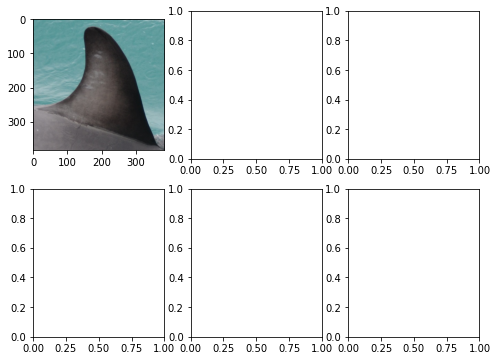

In [15]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_df = pd.read_csv('data/train_kfold.csv')
img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
img_dir = '/Users/macbook/works/train_images-384-384'
ids = train_df[train_df.sample_count == 1].individual_id.unique()

def random_show(train_df):
    iid = np.random.choice(ids)
    samples = train_df[train_df.individual_id == iid]
    imgs = []
    for i, row in samples.iterrows():
        img = cv2.imread(f'{img_dir}/{row.image}')[:, :, ::-1]
        if img is not None:
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(train_df)

In [16]:
ids

array(['cadddb1636b9', '4790ec346170', 'bc14b5054353', ...,
       '3509cb6a8504', 'e880e47c06a4', 'bc6fcab946c4'], dtype=object)

In [ ]:
x = pd.read_csv('data/train_image.csv')
x['r'] = x.h / x.w
x = x.sort_values('h')
x

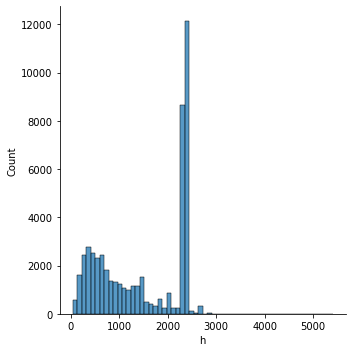

In [ ]:

_=sns.displot(x.h)

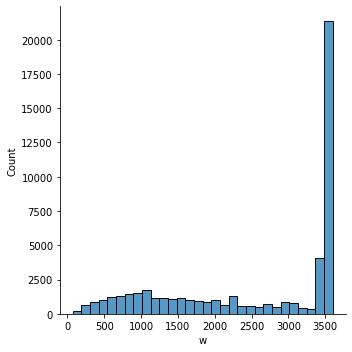

In [ ]:
_=sns.displot(x.w)

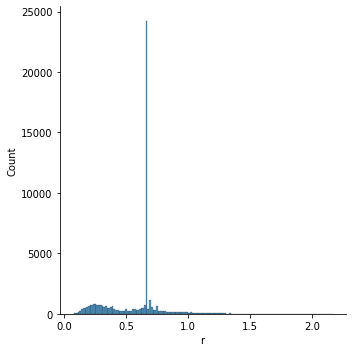

In [ ]:
_=sns.displot(x.r)

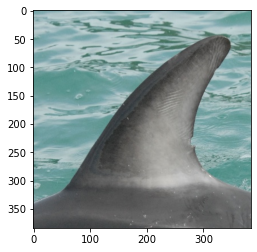

In [14]:
plt.imshow(cv2.imread(f'{img_dir}/ffbe97e98dc414.jpg')[:, :, ::-1])